In [19]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


In [20]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip -d glove
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
!gunzip cc.hi.300.vec.gz
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

--2025-04-15 15:13:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1118942272 (1.0G) [binary/octet-stream]
Saving to: ‘cc.hi.300.vec.gz’

cc.hi.300.vec.gz      0%[                    ]       0  --.-KB/s               

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


cc.hi.300.vec.gz    100%[===================>]   1.04G   227MB/s    in 4.3s    

2025-04-15 15:14:03 (247 MB/s) - ‘cc.hi.300.vec.gz’ saved [1118942272/1118942272]



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
# Load data
df = pd.read_csv("/kaggle/input/uli-dataset-all/train_hi_l1.csv")
annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']

def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    if not valid_votes:
        return None
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0

df['label'] = df[annotation_cols].apply(get_majority_label, axis=1)
df = df[['text', 'label']].dropna()
df['label'] = df['label'].astype(int)

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(normalize_text)


# Load HurtLex lexicon
hurtlex_df = pd.read_csv('/kaggle/input/hurtlex-hin/hurtlex_HI.tsv', sep='\t', engine='python', on_bad_lines='skip')
hurtlex_dict = {}
for _, row in hurtlex_df.iterrows():
    word = str(row['lemma']).strip().lower()
    cat = str(row['category']).strip()
    if word not in hurtlex_dict:
        hurtlex_dict[word] = set()
    hurtlex_dict[word].add(cat)

# Create category index
all_categories = sorted({c for cats in hurtlex_dict.values() for c in cats})
cat2idx = {c: i for i, c in enumerate(all_categories)}
num_cats = len(cat2idx)

# HurtLex vectorizer
def get_hurtlex_vector(text):
    vec = np.zeros(num_cats)
    for token in text.split():
        if token in hurtlex_dict:
            for cat in hurtlex_dict[token]:
                vec[cat2idx[cat]] = 1
    return vec

# Generate features
hurtlex_features = np.array([get_hurtlex_vector(text) for text in df['text']])





# GloVe-based tokenizer
max_features = 4479
max_len = 100
embed_size = 300

keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(df['text'])
X_seq = keras_tokenizer.texts_to_sequences(df['text'])
X_glove = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Load GloVe embeddings
embeddings_index = {}
with open('cc.hi.300.vec', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_features, embed_size))
for word, i in keras_tokenizer.word_index.items():
    if i < max_features and word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

In [22]:
# class FusionDataset(Dataset):
#     def __init__(self, texts, glove_inputs, labels, tokenizer, max_len=128):
#         self.texts = texts
#         self.glove_inputs = glove_inputs
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         bert_encoded = self.tokenizer.encode_plus(
#             self.texts[idx],
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )
#         return {
#             'input_ids': bert_encoded['input_ids'].squeeze(),
#             'attention_mask': bert_encoded['attention_mask'].squeeze(),
#             'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
#             'label': torch.tensor(self.labels[idx], dtype=torch.long)
#         }


class FusionDataset(Dataset):
    def __init__(self, texts, glove_inputs, labels, tokenizer, hurtlex_inputs=None, max_len=128):
        self.texts = texts
        self.glove_inputs = glove_inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.hurtlex_inputs = hurtlex_inputs
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        bert_encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': bert_encoded['input_ids'].squeeze(),
            'attention_mask': bert_encoded['attention_mask'].squeeze(),
            'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        if self.hurtlex_inputs is not None:
            item['hurtlex_input'] = torch.tensor(self.hurtlex_inputs[idx], dtype=torch.float)
        return item


In [23]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super(BiLSTMEncoder, self).__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [6]:
# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix, n_heads=4):
#         super(FusionClassifier, self).__init__()
#         self.bert_encoder = IndicBERTEncoder()
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)
#         self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=n_heads, batch_first=True)
#         self.classifier = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 2)
#         )

#     def forward(self, input_ids, attention_mask, glove_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)        # (B, 128)
#         x2 = self.bilstm_encoder(glove_input)                    # (B, 128)
#         combined = torch.stack([x1, x2], dim=1)                  # (B, 2, 128)
#         attn_output, _ = self.attention(combined, combined, combined)
#         pooled = attn_output.mean(dim=1)                         # (B, 128)
#         return self.classifier(pooled)                           # (B, 2)


In [7]:
# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix, hurtlex_input_dim):
#         super(FusionClassifier, self).__init__()

#         self.bert_encoder = IndicBERTEncoder()                      # x1 (B, 128)
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)       # x2 (B, 128)

#         # HurtLex encoder
#         self.hurtlex_fc = nn.Sequential(
#             nn.Linear(hurtlex_input_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 128)                                      # x3 (B, 128)
#         )

#         # Attention over 6 vectors: x1, x2, x3, x1-x2, x1*x2, x1-x3
#         self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)

#         # MLP head after attention
#         self.fusion_head = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 2)  # Output logits for binary classification
#         )

#     def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)         # (B, 128)
#         x2 = self.bilstm_encoder(glove_input)                     # (B, 128)
#         x3 = self.hurtlex_fc(hurtlex_input)                       # (B, 128)

#         fusion_seq = torch.stack([x1, x2, x3, x1 - x2, x1 * x2, x1 - x3], dim=1)  # (B, 6, 128)
#         attn_out, _ = self.attn(fusion_seq, fusion_seq, fusion_seq)             # (B, 6, 128)
#         pooled = attn_out.mean(dim=1)                                          # (B, 128)

#         return self.fusion_head(pooled)

In [24]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix, hurtlex_input_dim):
        super(FusionClassifier, self).__init__()

        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

        self.hurtlex_fc = nn.Sequential(
            nn.Linear(hurtlex_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128)  # Output size matches x1, x2
        )

        # New output dimension: 512 (x1, x2, x1-x2, x1*x2) + 128 (x3)
        self.fusion_head = nn.Sequential(
            nn.Linear(640, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
        x1 = self.bert_encoder(input_ids, attention_mask)   # (B, 128)
        x2 = self.bilstm_encoder(glove_input)               # (B, 128)
        x3 = self.hurtlex_fc(hurtlex_input)                 # (B, 128)
        x = torch.cat([x1, x2, x1 - x2, x1 * x2, x3], dim=1)  # (B, 640)
        return self.fusion_head(x)

In [25]:
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

# Split data
train_texts, val_texts, train_glove, val_glove, train_y, val_y = train_test_split(
    df['text'].tolist(), X_glove, y, test_size=0.2, random_state=42)

# HurtLex features
train_hurtlex = np.array([get_hurtlex_vector(t) for t in train_texts])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in val_texts])

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and Dataloaders
train_dataset = FusionDataset(train_texts, train_glove, train_y, tokenizer, train_hurtlex)
val_dataset = FusionDataset(val_texts, val_glove, val_y, tokenizer, val_hurtlex)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model, Optimizer, Loss
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Loop
train_losses, val_losses = [], []
best_f1 = 0.0

for epoch in range(13):
    print(f"\nEpoch {epoch + 1}/13")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            targets += labels.cpu().tolist()

    print("Unique predictions in this epoch:", set(preds))
    print("Unique true labels:", set(targets))

    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_losses.append(avg_val_loss)

    f1 = f1_score(targets, preds, average="weighted")
    precision = precision_score(targets, preds, average="weighted")
    recall = recall_score(targets, preds, average="weighted")

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_hurtlex_hindi_task1.pt")
        tokenizer.save_pretrained("fusion_tokenizer")
        print(f"Saved best model (F1: {best_f1:.4f})")


Epoch 1/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.7034 | Val Loss: 0.6181 | F1: 0.6767 | Precision: 0.6668 | Recall: 0.7056
Saved best model (F1: 0.6767)

Epoch 2/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.6405 | Val Loss: 0.5904 | F1: 0.6791 | Precision: 0.7068 | Recall: 0.7419
Saved best model (F1: 0.6791)

Epoch 3/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.6069 | Val Loss: 0.5762 | F1: 0.6767 | Precision: 0.6788 | Recall: 0.7266

Epoch 4/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5933 | Val Loss: 0.5521 | F1: 0.6979 | Precision: 0.7332 | Recall: 0.7540
Saved best model (F1: 0.6979)

Epoch 5/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5790 | Val Loss: 0.5386 | F1: 0.6938 | Precision: 0.6981 | Recall: 0.7363

Epoch 6/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5691 | Val Loss: 0.5397 | F1: 0.7003 | Precision: 0.7316 | Recall: 0.7540
Saved best model (F1: 0.7003)

Epoch 7/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5651 | Val Loss: 0.5336 | F1: 0.7029 | Precision: 0.7262 | Recall: 0.7524
Saved best model (F1: 0.7029)

Epoch 8/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5549 | Val Loss: 0.5549 | F1: 0.7279 | Precision: 0.7237 | Recall: 0.7339
Saved best model (F1: 0.7279)

Epoch 9/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5559 | Val Loss: 0.5272 | F1: 0.7067 | Precision: 0.7346 | Recall: 0.7565

Epoch 10/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5452 | Val Loss: 0.5385 | F1: 0.7262 | Precision: 0.7311 | Recall: 0.7565

Epoch 11/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5454 | Val Loss: 0.5307 | F1: 0.7193 | Precision: 0.7420 | Recall: 0.7621

Epoch 12/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5400 | Val Loss: 0.5240 | F1: 0.7169 | Precision: 0.7342 | Recall: 0.7581

Epoch 13/13


Unique predictions in this epoch: {0, 1}
Unique true labels: {0, 1}
Train Loss: 0.5389 | Val Loss: 0.5506 | F1: 0.7335 | Precision: 0.7295 | Recall: 0.7395
Saved best model (F1: 0.7335)


/tmp/ipykernel_31/236049540.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_hurtlex_hindi_task1.pt"))



Final Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.81      0.85      0.83       907
        Hate       0.52      0.45      0.48       333

    accuracy                           0.74      1240
   macro avg       0.66      0.65      0.65      1240
weighted avg       0.73      0.74      0.73      1240



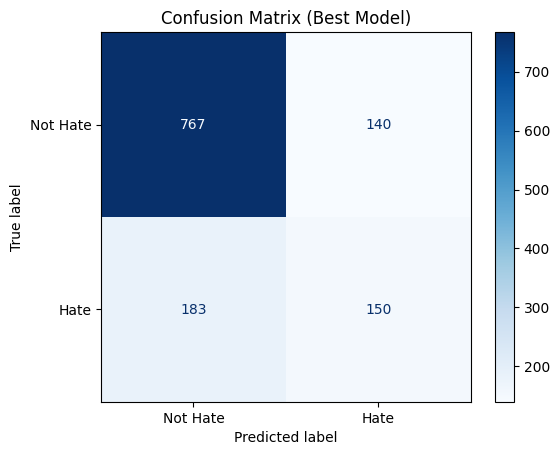

In [26]:
model.load_state_dict(torch.load("fusion_hurtlex_hindi_task1.pt"))
model.eval()

final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        final_preds += torch.argmax(outputs, dim=1).cpu().tolist()
        final_targets += labels.cpu().tolist()

# Final Report
print("\nFinal Classification Report:\n")
print(classification_report(final_targets, final_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(final_targets, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best Model)")
plt.show()

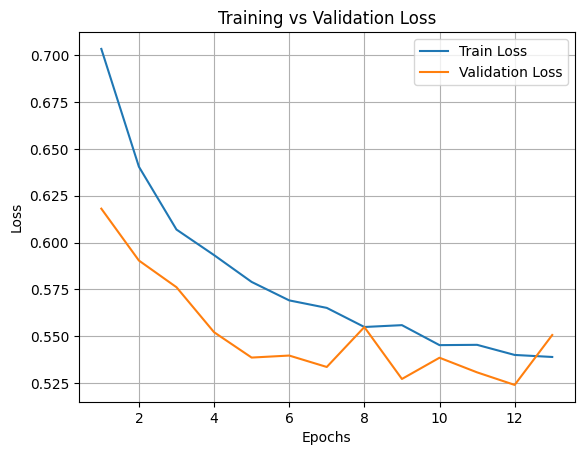

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/2552531426.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_hurtlex_hindi_task1.pt"))


Saved predictions to: Task1_output_English.csv

F1-score: 0.7619 | Precision: 0.7607 | Recall: 0.7632

Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.84      0.85      0.85      1158
        Hate       0.50      0.48      0.49       358

    accuracy                           0.76      1516
   macro avg       0.67      0.67      0.67      1516
weighted avg       0.76      0.76      0.76      1516



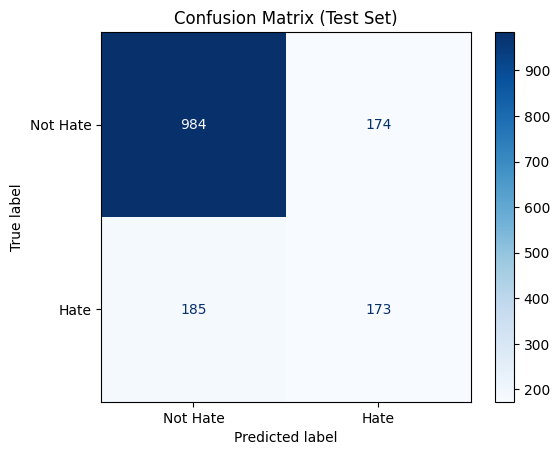

In [32]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess test data
test_df = pd.read_csv("/kaggle/input/uli-dataset-all/test_hi_l1.csv",engine='python')
annotation_cols = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
test_df['label'] = test_df[annotation_cols].apply(get_majority_label, axis=1)
test_df = test_df[['text', 'label']].dropna()
test_df['label'] = test_df['label'].astype(int)
test_df['text'] = test_df['text'].apply(normalize_text)

# Tokenize and encode
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_glove = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_labels = test_df['label'].tolist()
test_hurtlex = np.array([get_hurtlex_vector(text) for text in test_df['text']])
test_dataset = FusionDataset(test_df['text'].tolist(), test_glove, test_labels, tokenizer, hurtlex_inputs=test_hurtlex)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
model.load_state_dict(torch.load("fusion_hurtlex_hindi_task1.pt"))
model.eval()

# Run inference
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(labels.cpu().tolist())

output_df = pd.DataFrame({'id': np.arange(1, len(all_preds)+1), 'value': all_preds})
output_df.to_csv('/kaggle/working/Task1_output_English.csv', index=False)
print("Saved predictions to: Task1_output_English.csv")

f1 = f1_score(all_targets, all_preds, average="weighted")
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
print(f"\nF1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()